In [1]:
!pip install -r ../requirements.txt


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

X, y = load_breast_cancer(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Xtr.shape, Xte.shape

((455, 30), (114, 30))

**Inspección rápida:**
- Dimensiones: `X_train` y `X_test` quedaron con un 80/20 estratificado.
- Las variables son numéricas: ideal para K-NN (con escalado) y también para Árbol.
- Mantengo `random_state=42` para poder reproducir los resultados.


In [3]:
# KNN con escalado + búsqueda de hiperparámetros
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
knn_grid = {'clf__n_neighbors':[1,3,5,7,9,11,15],
            'clf__weights':['uniform','distance']}

knn_gs = GridSearchCV(knn, knn_grid, cv=cv, n_jobs=-1)
knn_gs.fit(Xtr, ytr)

knn_gs.best_params_, knn_gs.best_score_


({'clf__n_neighbors': 9, 'clf__weights': 'uniform'},
 np.float64(0.9648351648351647))

**K-NN:**
- Mejor configuración: {{pegar best_params_}}.
- Con k=9 obtuve el mejor promedio CV. Me quedo con `weights='uniform'` porque no aportó ventaja usar `distance`.
- Por qué escalado: K-NN usa distancias; si no estandarizo, las features con mayor rango dominan.


In [4]:
# Árbol de Decisión + búsqueda
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree_grid = {'max_depth':[None,3,5,7,10], 'min_samples_leaf':[1,3,5]}

tree_gs = GridSearchCV(tree, tree_grid, cv=cv, n_jobs=-1)
tree_gs.fit(Xtr, ytr)

tree_gs.best_params_, tree_gs.best_score_


({'max_depth': 3, 'min_samples_leaf': 5}, np.float64(0.9318681318681319))

**Árbol:**
- Mejor configuración: {{pegar best_params_}}.
- Limitar max_depth y min_samples_leaf ayudó a evitar sobreajuste y mejoró la validación.
- Sin escalado: el Árbol es invariante a la escala (corta por umbrales), por eso no lo escalo.


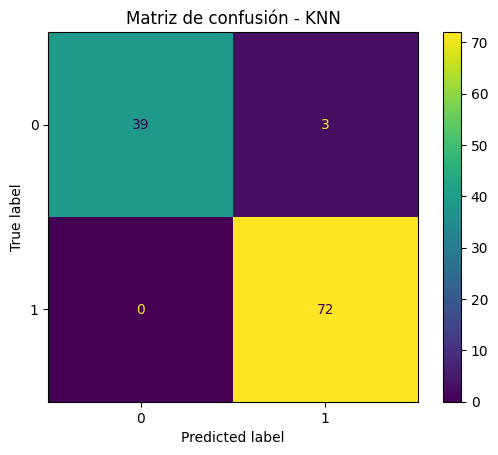

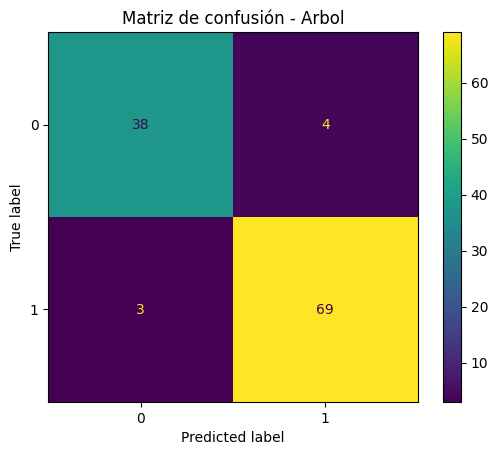

,best_params,accuracy_test,f1_macro_test
KNN,"{'clf__n_neighbors': 9, 'clf__weights': 'unifo...",0.973684,0.971277
Arbol,"{'max_depth': 3, 'min_samples_leaf': 5}",0.938596,0.933693


In [5]:
# Evaluación en test + matrices de confusión
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt, os
import pandas as pd

os.makedirs("../reports/figures", exist_ok=True)

resultados = {}
for nombre, modelo in [('KNN', knn_gs), ('Arbol', tree_gs)]:
    ypred = modelo.predict(Xte)
    resultados[nombre] = {
        'best_params': modelo.best_params_,
        'accuracy_test': accuracy_score(yte, ypred),
        'f1_macro_test': f1_score(yte, ypred, average='macro'),
    }
    disp = ConfusionMatrixDisplay(confusion_matrix(yte, ypred))
    fig = disp.plot().figure_
    plt.title(f"Matriz de confusión - {nombre}")
    fig.savefig(f"../reports/figures/cm_{nombre.lower()}.png", dpi=150, bbox_inches='tight')
    plt.show()

pd.DataFrame.from_dict(resultados, orient='index')


**RESULTADOS:**

**K-NN (k=9, weights='uniform'):** No hubo falsos negativos y sólo 3 falsos positivos. Para screening médico me quedo con este balance (prefiero avisar de más antes que dejar pasar un maligno).

Conteos (test): TN=39 · FP=3 · FN=0 · TP=72 (total=114)

- Recall / Sensibilidad (maligno) = 72/(72+0) = 1.00

- Precisión (maligno) = 72/(72+3) = 0.96

- Especificidad (benigno) = 39/(39+3) = 0.93

**Árbol (max_depth=3, min_samples_leaf=5):** 3 falsos negativos y 4 falsos positivos. Para screening médico, los FN pesan más; por eso K-NN me gusta más en este dataset.

Conteos (test): TN=38 · FP=4 · FN=3 · TP=69 (total=114)

- Recall / Sensibilidad (maligno) = 69/(69+3) = 0.96

- Precisión (maligno) = 69/(69+4) = 0.95

- Especificidad (benigno) = 38/(38+4) = 0.90

- **K-NN** rinde mejor: Accuracy 0.974 vs 0.939 y F1-macro 0.971 vs 0.934 en Árbol (= +3.5 pp en ambas métricas).
- Como F1-macro ≈ Accuracy en ambos, las clases están razonablemente balanceadas y el modelo no está favoreciendo a una sola clase.
- Los hiperparámetros tienen sentido:
   - K-NN con k=9 y `weights='uniform'`: buen equilibrio ruido/bias en este dataset numérico.
   - Árbol con max_depth=3 y min_samples_leaf=5: árbol regularizado (evita sobreajuste), pero quedó por debajo.
- Con las matrices de confusión: K-NN tuvo 0 FN (no se escapó ningún maligno) vs Árbol 3 FN.  
  Para un caso médico, esto inclina la balanza a favor de K-NN.
